In [1]:
import os
# import timm
from tqdm import tqdm
import statistics
from statistics import mode
import glob
import pandas as pd
import numpy as np

# import torch
# import torch.nn as nn

import matplotlib.pyplot as plt

# from series_loader import build_dataloader
# from torch.utils.data import Dataset, DataLoader, Subset
import nibabel as nib
import cv2


model_name = 'efficientnet_b2'
ckp_path = '/home/single1/BACKUP/binhdao/binhdao/weights/EfficientNet_b2_224.pth'

label_dict = {0: 'Non Contrast', 1: 'Venous', 2: 'Arterial', 3: 'Others'}

# data_path = 
data = glob.glob('/home/single1/BACKUP/binhdao/lits/Training_Batch2/media/nas/01_Datasets/CT/LITS/Training_Batch_2/volume*')

In [ ]:
df = pd.read_csv('LITS_prediction.csv')
df1 = pd.read_csv('LITS_prediction_b1.csv')
df = pd.concat([df, df1]).reset_index(drop=True)
df

In [ ]:
np.unique(df.Prediction.values, return_counts=True)

In [ ]:
window_width = 400
window_center = 50

import numpy as np
def apply_window(img, ww: float, wc: float):
    '''
    Apply HU window on a HU image
    
    Args:
        img: Image to transform
        ww: Window width
        wc: Window center
    '''
    lower_bound = wc - ww/2
    upper_bound = wc + ww/2
    
    img[img < lower_bound] = lower_bound
    img[img > upper_bound] = upper_bound

    img = (img - wc) / ww * (upper_bound - lower_bound) + lower_bound
    
    return img

def preprocess_image(img, ww: float, wc: float,):
    '''
    Preprocess raw image extracting from dicom files.
    1. Apply formula: 
        new_img = old_img * rescale_slope + rescale_intercept
    2. Apply HU window
    
    Args:
        img: input image (numpy array)
        ww: window width of HU window
        wc: window center of HU window
        rescale_slope: float
        rescale_intercept: float
        
    Return
    '''
    img = apply_window(img, ww, wc)

    return img

In [ ]:
def build_model(model_name):
    model = timm.create_model(model_name, pretrained=False)
    num_class = 4
    if 'resnet' in model_name:
        model.fc = nn.Linear(512, num_class)
    elif 'efficientnet' in model_name:
        model.classifier = nn.Linear(model.classifier.in_features, num_class)
    return model

def load_model(model, path):
    if os.path.isfile(path):
        ckpt = torch.load(path, 'cpu')
        model.load_state_dict(ckpt.pop('state_dict'))
        start_epoch, best_metric = ckpt['epoch'], \
                                    ckpt['best_metric']

    return model 

model = build_model(model_name)
model_ckp = load_model(model, ckp_path)
model.eval()
model.cuda()

In [ ]:
class Data(Dataset):
    def __init__(self, imgs):
        """A Dataset object that load all data for running

        Args:
            cfg (CfgNode): Config object containing running configuration
            mode (str): Model running mode
        """
        self.imgs = imgs.transpose(2,1,0)
        

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = cv2.flip(img, 0)
        img = preprocess_image(img, window_width, 
                               window_center).astype('float')
        img = cv2.normalize(img, None,
                        alpha = 0, beta = 255,
                        norm_type = cv2.NORM_MINMAX,
                        dtype = cv2.CV_32F)
        
        img = np.stack((img,)*3, axis=-1)
        
        
        # RESIZE IMAGE
        img = cv2.resize(img, (224,224), \
                        interpolation=cv2.INTER_AREA)
        
        

        img = img.transpose(2,0,1)

        return img

def build_dataloader(imgs):
    '''Build dataloader

    Returns:
        dataloader: Dataloader object 
    '''

    dataset = Data(imgs)
    # DEBUG: Only take a subset of dataloader to run script
    dataloader = DataLoader(dataset, 2, \
                            pin_memory=False, shuffle=False, \
                            drop_last=False, num_workers=4)
    return dataloader

In [ ]:
def predict_scan(nii_path, model):

    img = nib.load(nii_path)
    img = img.get_fdata()

    dataloader = build_dataloader(img)
    preds = list()

    for image in tqdm(dataloader):
        with torch.no_grad():
            image = image.float().cuda()
            output = model(image)
        sigmoid = nn.Sigmoid()
        pred = torch.argmax(sigmoid(output), 1)

        # Convert target, prediction to numpy
        pred = list(pred.detach().cpu().numpy())
        preds += pred

    series_pred = mode(preds)
    
    return series_pred

In [ ]:
def visualize_scans(scan_path):
    imgs = nib.load(scan_path)
    imgs = imgs.get_fdata()
    
    imgs = imgs.transpose(2,1,0)
    
    for i in range(len(imgs)):
        img = imgs[i]
        img = cv2.flip(img, 0)
        img = preprocess_image(img, window_width, 
                               window_center).astype('float')
        img = cv2.normalize(img, None,
                        alpha = 0, beta = 255,
                        norm_type = cv2.NORM_MINMAX,
                        dtype = cv2.CV_32F)
        img = np.around(img, decimals=0).astype('int')
        img = np.stack((img,)*3, axis=-1)
        
        save_dir = 'LITS_anal'
        scan_dir = f'{save_dir}/{scan_path.split("/")[-1].split(".")[0]}'
        if not os.path.isdir(scan_dir):
            os.mkdir(scan_dir)
        
        filename = f'{scan_dir}/{i}.jpeg'
        cv2.imwrite(filename,img)  

In [ ]:
path1 = '/home/single1/BACKUP/binhdao/lits/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training_Batch_1/'
path2 = '/home/single1/BACKUP/binhdao/lits/Training_Batch2/media/nas/01_Datasets/CT/LITS/Training_Batch_2/'
scans_path = glob.glob(f'{path1}volume*') + glob.glob(f'{path2}volume*')

for scan in tqdm(scans_path):
    visualize_scans(scan)

In [ ]:
scan = scans_path[2]
imgs = nib.load(scan)
imgs = imgs.get_fdata()

imgs = imgs.transpose(2,1,0)

left, right, lower, upper = imgs.shape[1], 0, imgs.shape[2], 0
for i in range(len(imgs)):
    img = imgs[i]
    img = preprocess_image(img, window_width, 
                           window_center).astype('float')
    img = cv2.normalize(img, None,
                    alpha = 0, beta = 255,
                    norm_type = cv2.NORM_MINMAX,
                    dtype = cv2.CV_32F)
    img = np.around(img, decimals=0).astype('int')
    
    bin_img = img != 0
    # CUT IMAGE
    contour_img = contour(bin_img)
    row, col = np.where(contour_img == 1)
    row.sort()
    col.sort()

    cur_left, cur_right, cur_lower, cur_upper = row[0], row[-1], col[0], col[-1]
    if cur_left < left:
        left = cur_left
    if cur_right > right:
        right = cur_right
    if cur_lower < lower:
        lower = cur_lower
    if cur_upper > upper:
        upper = cur_upper

    cut_image = img[cur_left : cur_right, cur_lower: cur_upper]
#     plt.imshow(cut_image)
#     plt.show()

imgs = imgs[:, left:right, lower:upper]
for i in range(len(imgs)):
    img = imgs[i]
    plt.imshow(img)
    plt.show()
    



In [2]:
def contour(bin_img):
    image = bin_img.astype('uint8') # if this not a binary image, you can threshold it
    output = image.copy()
    contours,hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) != 0:
        # the contours are drawn here
        cv2.drawContours(output, contours, -1, 255, 3)
        
        #find the biggest area of the contour
        contours.sort(key = cv2.contourArea)
        c = contours[-1]
        
        # Create rectangular bounding box for the contour with biggest area
        x,y,w,h = cv2.boundingRect(c)

    return x, y, w, h

In [10]:
img = '/home/single1/BACKUP/binhdao/binhdao/Split_data/data/test/1.2.840.113619.2.278.3.717616.204.1584947878.383/3_Non_-314.000.jpg'
img = cv2.imread(img)[:,:,0]
cv2.imwrite('demo_crop_original.png', img)

img = np.around(img, decimals=0).astype('int')
bin_img = img != 0

x,y,w,h = contour(bin_img)
cv2.imwrite('demo_crop.png', img[y:y+h, x:x+w])

True

In [3]:
# (depth, w, h)
def cut_image(image_3d):
#     left, right, lower, upper = image_3d.shape[1], 0, image_3d.shape[2], 0
    left, right, lower, upper = list(), list(), list(), list()
    for i in range(len(image_3d)):
        img = image_3d[i]
        img = np.around(img, decimals=0).astype('int')

        bin_img = img != 0
        # CUT IMAGE
        x, y, w, h = contour(bin_img)

        left.append(y)
        right.append(y + h)
        lower.append(x)
        upper.append(x + w)

#         x = img[y:y+h, x:x+w]
    
#     left.sort()
#     rigiht.sort()
#     lower.sort()
#     upper.sort()
    left, right, lower, upper = left[0], right[-1], lower[0], upper[-1]

    image_3d = image_3d[:, left:right, lower:upper]
    
    return image_3d
    

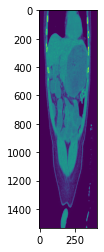

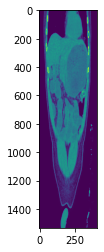

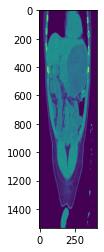

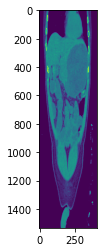

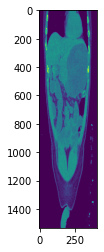

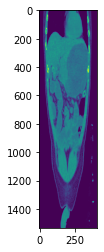

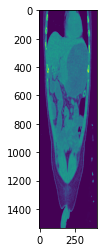

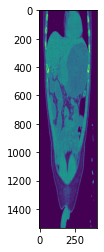

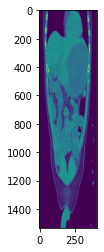

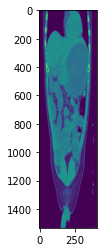

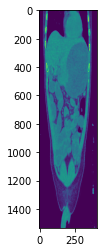

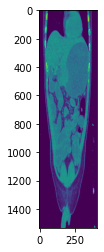

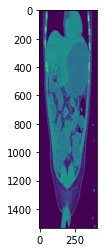

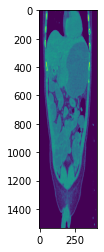

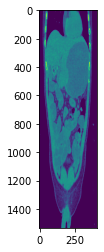

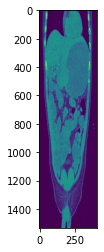

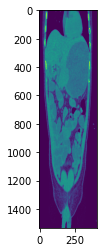

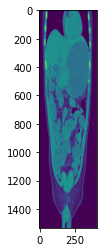

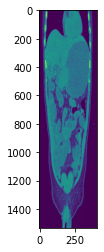

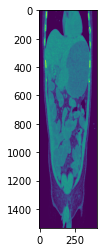

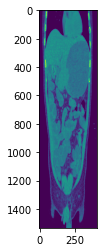

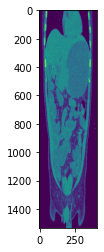

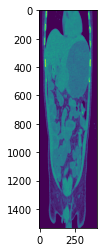

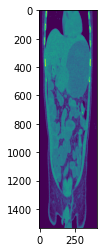

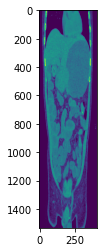

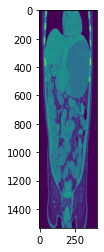

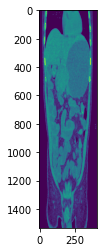

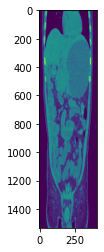

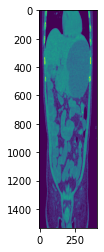

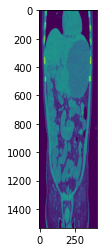

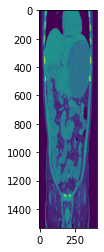

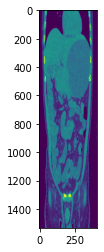

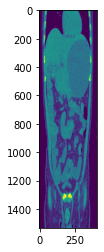

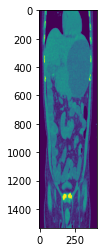

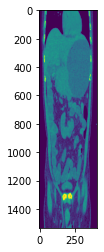

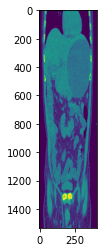

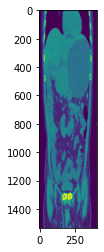

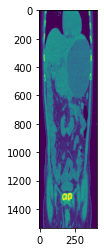

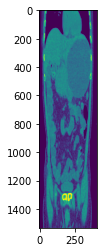

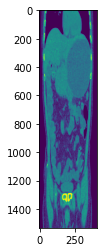

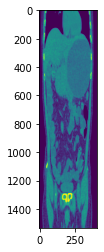

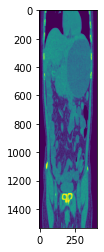

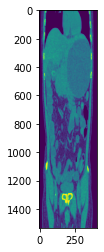

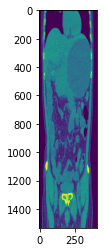

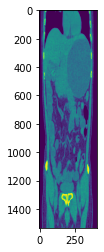

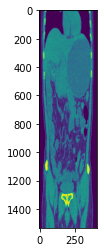

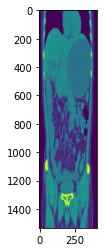

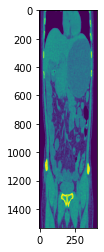

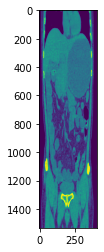

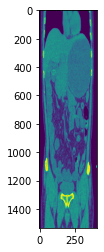

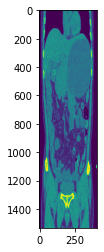

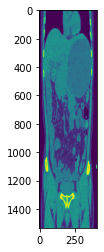

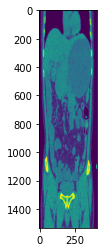

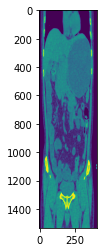

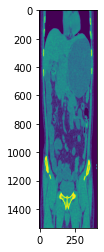

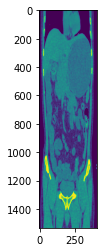

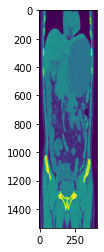

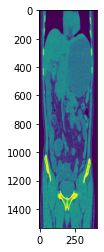

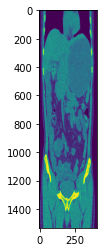

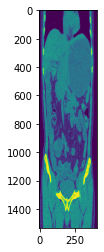

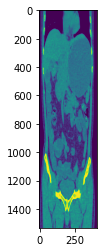

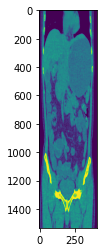

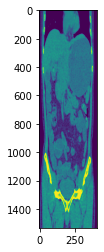

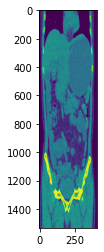

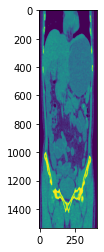

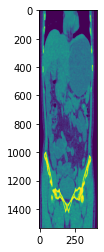

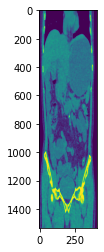

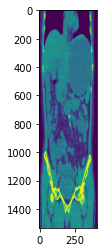

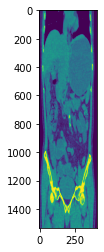

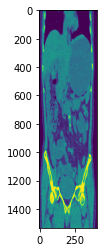

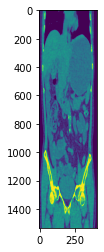

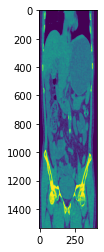

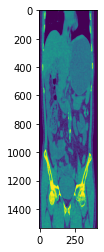

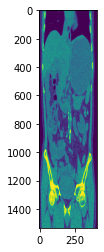

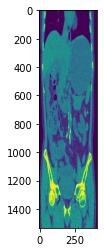

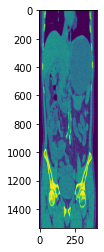

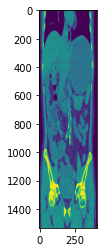

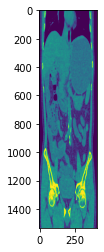

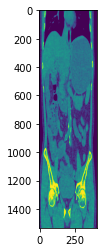

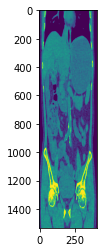

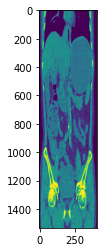

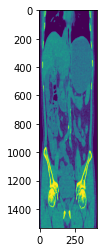

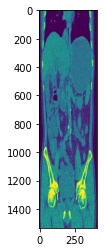

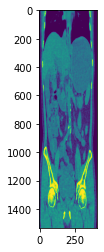

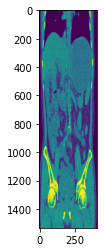

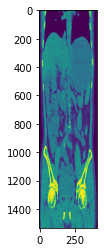

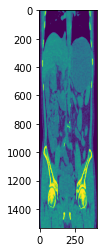

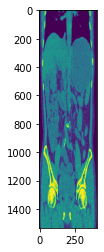

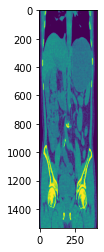

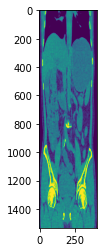

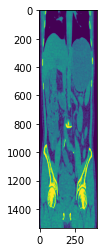

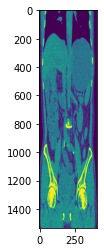

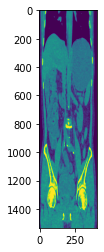

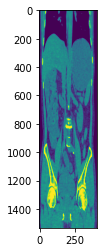

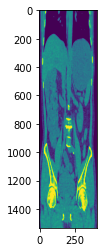

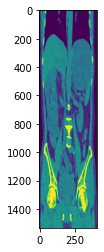

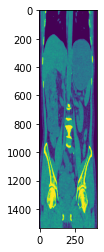

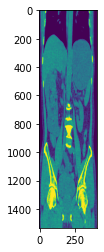

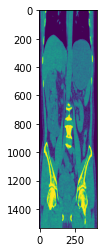

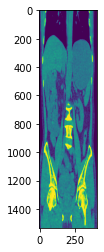

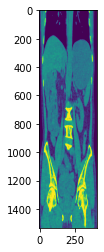

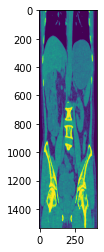

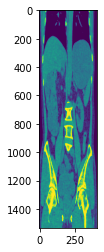

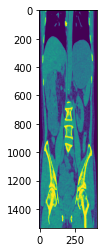

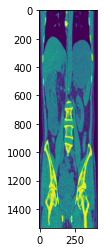

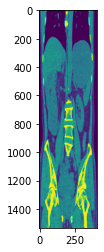

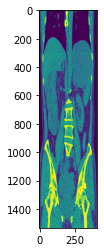

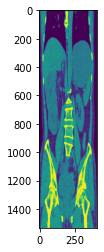

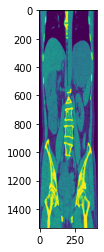

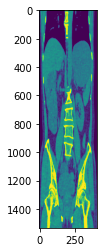

KeyboardInterrupt: 

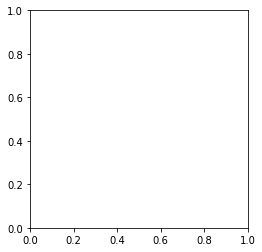

In [4]:
def myFunc(e):
    e = e.split('/')[-1].split('_')[-1].split('.')
    e = '.'.join(e[:-1])
    e = float(e)
    return e

path = '/home/single1/BACKUP/binhdao/binhdao/Split_data/data/train/1.2.392.200036.9116.2.5.1.37.2418751871.1432695579.168588'
img = glob.glob(f'{path}/*Non*')
img.sort(key=myFunc)

image_3d = []
for scan in img:
    gray = cv2.cvtColor(cv2.imread(scan), cv2.COLOR_BGR2GRAY)
    image_3d.append(gray)
    
image_3d = np.stack(image_3d, axis=0)
image_3d = cut_image(image_3d)

image_3d = image_3d.transpose(1,0,2)
start = round(len(image_3d) * 1/4)
end = round(len(image_3d) * 3/4)
# for i in range(start, end):
#     img = image_3d[i]
# #     img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
#     plt.imshow(img)
#     plt.show()